This process will take all the 2018-2019 periods as features and will use those to predict reviews for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model may indicate COVID-related change.

In [1]:
import datetime
import numpy as np
import pandas as pd

import aggregator as ag
import monthly_modeler as mm

In [2]:
#data_file_name_review = "distributed_data_collection/databases/review_data_sample.csv"
#data_file_name_book = "distributed_data_collection/databases/book_data_sample.csv"

data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 9, 30)

#book_columns = ["num_reviews", "num_ratings", "avg_rating"] #BASELINE
book_columns = ["num_reviews", "num_ratings", "avg_rating", "book_language", "series", "book_author"]

Theoretically, we could test against multiple grains (ie, day, week, month, quarter). However, I am only working with month. I ruled out the quarterly grain because it wouldn't include enough 2020 time periods to observe a trend in model performance over time. Then because the maximum monthly review counts were in the seventies, I didn't feel I could split those further.

I want to drop binary feature columns which have a small number of values. The linear regression regularization will do a rigorous feature selection, so this step is mostly to reduce the amount of data that it has to process.

In [3]:
data_aggregator = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns, start_date, end_date, "month")
data_aggregator.aggregate("by_book")
data = data_aggregator.sparsity_filter(2)

time_periods_post = data.aggregator.get_annual_time_periods(2020)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.


I want to use the same test/train split for every time period, so I need to make the split before selecting which period will be the feature. 

In [6]:
perc_train = 0.75

data = data.iloc[np.random.permutation(data.index)].reset_index(drop=True) #SHUFFLES DATA

num_observations_total = len(data)
num_observations_train = int(num_observations_total* perc_train)
num_observations_test = num_observations_total - num_observations_train

data_train = data.head(num_observations_train).reset_index(drop = True)
data_test = data.tail(num_observations_test).reset_index(drop = True)

We want to iterate through: logorithmic transformation, regularization type, and alpha value. For the moment, I am turning logorithmic transformation off. It's pretty clear that it has no impact, and I don't want to keep running it while I experiment with other aspects of the modeling process.

In [18]:
#alpha_list = [1] #BASELINE
alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]

#regression_types_list = ["linear"] #BASELINE
regression_types_list = ["linear", "ridge", "lasso"]

#is_log_options = [False, True]
is_log_options = [False] 

Here goes on modeling! We will select the best model for each time period based on MSE. The performance df captures the overall predictiveness of pre-period data on post-period data. We expect to see declines due to concept drift. Sharp dropoffs in performance might suggest larger changes in reading trends.

In [19]:
regression_processor = mm.Regression_Processor(data_train, data_test, time_periods_post, regression_types_list, is_log_options, alpha_list)
performance_df, model_dict = regression_processor.get_optimal_models()

print(performance_df.round(3))

10/253 models processed
20/253 models processed
30/253 models processed
40/253 models processed
50/253 models processed
60/253 models processed
70/253 models processed
80/253 models processed
90/253 models processed
100/253 models processed
110/253 models processed
120/253 models processed
130/253 models processed
140/253 models processed
150/253 models processed
160/253 models processed
170/253 models processed
180/253 models processed
190/253 models processed
200/253 models processed
210/253 models processed
220/253 models processed
230/253 models processed
240/253 models processed
250/253 models processed
253/253 models processed
   post_period regression_type is_log   alpha  mse_test  r2_train  r2_test
0      2020-01           ridge  False   1.000     4.394     0.813    0.745
1      2020-02           ridge  False   1.000     2.025     0.724    0.690
2      2020-03           ridge  False   1.000     2.600     0.706    0.672
3      2020-04           ridge  False   1.000     4.149    

This is where it's really at! Understanding what features are most important to each model can help us understand the drivers of reading in each period.

In [20]:
coefficient_df = regression_processor.get_coefficient_df()
coefficient_df = regression_processor.print_top_coefficients()

                                                    review_count 2020-01
feature_name                                                            
series_Alex Stern                                               8.426314
book_author_Jeanine Cummins                                     7.966083
book_author_Fredrik Backman  Neil Smith (Transl...             -3.801619
book_author_Yann Martel                                         3.712742
book_author_Casey McQuiston                                     3.072889
book_author_George Orwell                                       2.857795
book_author_Delia Owens                                         2.677677
book_author_George Saunders                                    -2.467010
book_author_Laura Hillenbrand                                  -2.364236
book_author_Taylor Jenkins Reid                                 2.196226
                                                    review_count 2020-02
feature_name                                       

I also want to understand the relative importance of each historical period. Even if it isn't the main driver, it should give some indication of whether trends are changing.

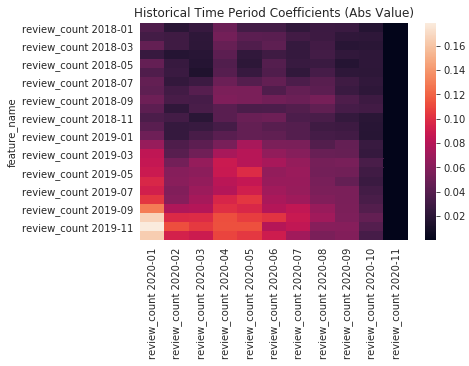

In [21]:
pre_period_importance = regression_processor.get_pre_period_importance()